In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
!pip install livelossplot
!pip install pytorch_forecasting
!pip install scikit-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 749.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_ex

In [ ]:
import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

from livelossplot import PlotLosses

from joblib import Parallel, delayed
import joblib

import seaborn as sns

import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import shap
import time
import sklearn.metrics
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import statistics

In [ ]:

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class SumAxis(nn.Module):
  def __init__(self, axis=1):
    super().__init__()
    self.axis=axis

  def forward(self, x):
    return torch.sum(x, axis=1)

In [ ]:
class CreationNet(nn.Module):
  def __init__(self, features_in=40, activation=nn.ReLU):
    super().__init__()
    self.booking_embedding = nn.Sequential(
        nn.Linear(features_in, 128),
        activation(),
        nn.Linear(128, 128),
        # activation()
    )

    self.lstm = nn.LSTM(128, 128, 1, batch_first=True) #input size, hidden dim, n_layers

    self.next_event_net = nn.Sequential(
        nn.Linear(128, 64),
        activation(),
        nn.Linear(64, 32),
        activation(),
        nn.Linear(32, 1),
        nn.ReLU()
    )
  def forward(self, x):
    """
    x shape: [batch_size, sequence_length, n_features]
    """
    seq_length = (~(x == 0).all(axis=2)).sum(axis=1).detach().tolist()
    seq_embedded = self.booking_embedding(x)  # output shape: [batch_size, sequence length, 128]
    packed_seq_bach = torch.nn.utils.rnn.pack_padded_sequence(seq_embedded, lengths = torch.Tensor(seq_length).to("cpu"), batch_first = True, enforce_sorted=False)

    _, (lstm_hidden, _) = self.lstm(packed_seq_bach) #IS misschien al de laatste, dan hoeft bij de volgende lijn geen -1 te stan tussen de brackets maar :
    next_event_net_out = self.next_event_net(lstm_hidden)
    return next_event_net_out.squeeze(2)


In [ ]:
class HotelDataset(Dataset):
  def __init__(self, split='train'):
    """
    1. Load the data, e.g. df= pd.Feather load ()

    Data preprocessing:
    - Make sure fast indexing, so, maybe use guest_id as index
    - New time index, running from 1 (first time) ... last_time
    - Data needs to be all numerical, use encoders to encode data if needed before hand
    - Normalize data
    """
    self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_balancedII_data_standardscaler', index_col = [0,1])
    self.scaled_df = self.scaled_df.drop(["amount_times_visited", "weekday_arrival_date", "weekday_creation_date"], axis = 1)
    self.scaled_df.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.scaled_df.index])
    self.scaled_df = self.scaled_df.iloc[1:, :]
    missing_rows = self.scaled_df.isnull().any(axis = 1)
    self.scaled_df = self.scaled_df[~missing_rows]
    guests = self.scaled_df.index.get_level_values(0)
    # self.guest_idx = np.unique(self.scaled_df.index.get_level_values(0))
    self.guest_idx = np.unique([guests[0]] + list(guests[1:].astype(str)))
    self.split_indexes = self.train_test_split(split)
    self.y = pd.read_csv('output/10_selected_guest_data/y_balancedII_data', index_col = [0,1])
    self.y.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.y.index])
    self.y = self.y[~missing_rows.values]
    return

  def train_test_split(self, split):
    np.random.seed(42)
    max_guests = len(self.guest_idx)
    n = int(max_guests * 0.8)

    indexes = np.random.permutation(max_guests)

    if split == "train":
      return indexes[:n]
    elif split == "validation":
      return indexes[n:]

  def __len__(self):
    """
    np.unique(guests)
    """
    return len(self.split_indexes)

  def __getitem__(self, idx):
    """
    idx --> guest_id
    self.df[idx]
    """

    idx = self.split_indexes[idx]
    chosen_guest = self.scaled_df.loc[self.guest_idx[idx]]
    y_guest = self.y.loc[self.guest_idx[idx]]
    y_array = y_guest.to_numpy().squeeze(1)
    columns_guest = chosen_guest.columns
    guest_array = chosen_guest.to_numpy()  # [sequence length, columns]

    cut_off = np.random.randint(1, guest_array.shape[0]) if guest_array.shape[0] > 1 else 1
    return torch.Tensor(guest_array[:cut_off, :]), y_array[cut_off -1]


In [ ]:

class NextEventLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss(reduction='none')

  def forward(self, y_target, y_pred):

    mse_loss = self.mse(y_pred, y_target)
    mse_filtered = torch.sum(mse_loss[y_target != -1000])
    return mse_filtered


In [ ]:
def pad_batch(batch):
  booking_seqs, labels = zip(*batch)
  seq_length = [len(booking) for booking in booking_seqs]
  padded_booking_seqs = pad_sequence(booking_seqs, batch_first=True, padding_value=-10)
  return padded_booking_seqs, torch.Tensor(labels), seq_length

In [ ]:
model = CreationNet(features_in=21)
data_train = HotelDataset(split='train')
data_validate = HotelDataset(split='validation')

In [ ]:
train_loader = DataLoader(data_train, batch_size=256, collate_fn=pad_batch)
valid_loader = DataLoader(data_validate, batch_size=256, collate_fn=pad_batch)

optimizer = Adam(model.parameters())
loss_fn = NextEventLoss()
num_epochs = 20

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
data, labels, seq_lens = next(iter(train_loader))
summary(model, input_data = data)

Layer (type:depth-idx)                   Output Shape              Param #
CreationNet                              [1, 512]                  --
├─Sequential: 1-1                        [512, 8, 128]             --
│    └─Linear: 2-1                       [512, 8, 128]             2,816
│    └─ReLU: 2-2                         [512, 8, 128]             --
│    └─Linear: 2-3                       [512, 8, 128]             16,512
├─LSTM: 1-2                              [4096, 128]               132,096
├─Sequential: 1-3                        [1, 512, 1]               --
│    └─Linear: 2-4                       [1, 512, 64]              8,256
│    └─ReLU: 2-5                         [1, 512, 64]              --
│    └─Linear: 2-6                       [1, 512, 32]              2,080
│    └─ReLU: 2-7                         [1, 512, 32]              --
│    └─Linear: 2-8                       [1, 512, 1]               33
│    └─ReLU: 2-9                         [1, 512, 1]               

In [ ]:
def train_next(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, device = "cuda"):
  liveloss = PlotLosses()
  model.to(device)
  for epoch in range(num_epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    epoch_loss_train = 0.0
    for i,data in enumerate(train_loader):#, 0)
      inputs, labels, seq_length = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      next_event_pred = model(inputs)

      loss = loss_fn(labels.unsqueeze(0), next_event_pred)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      epoch_loss_train += loss.item()
      if i % 200 == 199:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (200*32):.3f}')
          running_loss = 0.0

    logs['train_loss value'] = epoch_loss_train / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
      valid_loss = 0

      for i,data in enumerate(valid_loader):#, 0)
        inputs, labels, seq_length = data
        inputs, labels = inputs.to(device), labels.to(device)
        next_event_pred = model(inputs)
        loss = loss_fn(labels.unsqueeze(0), next_event_pred)
        valid_loss += loss.item()

      # print(f'[validation {epoch + 1}] loss: {valid_loss / (i*32):.3f}')
    logs['valid_loss value'] = valid_loss / len(valid_loader.dataset)

    if (epoch + 1 > 3) and logs['valid_loss value'] > 200000:
      break

    print(logs)
    liveloss.update(logs)
    liveloss.send()

In [ ]:
def predict(model, valid_loader, device = "cuda"):
  model.to(device)
  model.eval()
  next_event_pred_list = []
  labels_list = []
  with torch.no_grad():

    for i,data in enumerate(valid_loader):#, 0)
      inputs, labels, seq_length = data
      # print(inputs)
      seq_length = torch.Tensor(seq_length)
      inputs, labels, seq_length = inputs.to(device), labels.to(device), seq_length.to(device)
      # print(labels)
      next_event_pred = model(inputs)
      # print(inputs)
      next_event_pred_list.extend(next_event_pred.cpu().tolist())
      labels_list.extend(labels.cpu().tolist())
    labels_list = pd.Series(labels_list)
    next_event_pred_list = pd.Series(next_event_pred_list)
    mask = labels_list != -1000
    labels_list = labels_list[mask]
    # print(labels_list != -1000)
    new_next_event_pred_list = []
    for next_event in next_event_pred_list:
      new_next_event_pred_list = new_next_event_pred_list + next_event
    new_next_event_pred_list = np.array(new_next_event_pred_list)
    new_next_event_pred_list = new_next_event_pred_list[(mask).values]

  return pd.Series(new_next_event_pred_list), labels_list

Specific trained models


In [ ]:
stringlist = ["Trained_models/lstmsnext_model_finaloriginal_0_513.pkl", "Trained_models/lstmsnext_model_finaloriginal_1_492.pkl", "Trained_models/lstmsnext_model_finaloriginal_2_490.pkl", "Trained_models/lstmsnext_model_finaloriginal_3_492.pkl", "Trained_models/lstmsnext_model_finaloriginal_4_489.pkl", "Trained_models/lstmsnext_model_finaloriginal_5_490.pkl", "Trained_models/lstmsnext_model_finaloriginal_6_491.pkl", "Trained_models/lstmsnext_model_finaloriginal_7_495.pkl", "Trained_models/lstmsnext_model_finaloriginal_8_502.pkl", "Trained_models/lstmsnext_model_finaloriginal_9_492.pkl"]

In [ ]:
stringlistbusiness = ["Trained_models/lstmsnext_model_finalbusiness_0_54.pkl", "Trained_models/lstmsnext_model_finalbusiness_1_28.pkl", "Trained_models/lstmsnext_model_finalbusiness_3_31.pkl", "Trained_models/lstmsnext_model_finalbusiness_4_28.pkl", "Trained_models/lstmsnext_model_finalbusiness_5_27.pkl", "Trained_models/lstmsnext_model_finalbusiness_6_27.pkl", "Trained_models/lstmsnext_model_finalbusiness_7_28.pkl", "Trained_models/lstmsnext_model_finalbusiness_8_28.pkl", "Trained_models/lstmsnext_model_finalbusiness_9_29.pkl"]

In [ ]:
stringlistleisure = ["Trained_models/lstmsnext_model_finalleisure_0_511.pkl", "Trained_models/lstmsnext_model_finalleisure_1_495.pkl", "Trained_models/lstmsnext_model_finalleisure_2_489.pkl", "Trained_models/lstmsnext_model_finalleisure_3_488.pkl", "Trained_models/lstmsnext_model_finalleisure_4_490.pkl", "Trained_models/lstmsnext_model_finalleisure_5_499.pkl", "Trained_models/lstmsnext_model_finalleisure_6_490.pkl", "Trained_models/lstmsnext_model_finalleisure_7_490.pkl", "Trained_models/lstmsnext_model_finalleisure_8_489.pkl", "Trained_models/lstmsnext_model_finalleisure_9_500.pkl"]

In [ ]:
stringlistbalancedI = ["Trained_models/lstmsnext_model_finalbalancedI_0_468.pkl", "Trained_models/lstmsnext_model_finalbalancedI_1_435.pkl", "Trained_models/lstmsnext_model_finalbalancedI_2_445.pkl", "Trained_models/lstmsnext_model_finalbalancedI_3_438.pkl", "Trained_models/lstmsnext_model_finalbalancedI_4_435.pkl", "Trained_models/lstmsnext_model_finalbalancedI_5_432.pkl", "Trained_models/lstmsnext_model_finalbalancedI_6_432.pkl", "Trained_models/lstmsnext_model_finalbalancedI_7_438.pkl", "Trained_models/lstmsnext_model_finalbalancedI_8_441.pkl", "Trained_models/lstmsnext_model_finalbalancedI_9_436.pkl"]

In [ ]:
stringlistbalancedII = ["Trained_models/lstmsnext_model_finalbalancedII_0_298.pkl", "Trained_models/lstmsnext_model_finalbalancedII_1_271.pkl", "Trained_models/lstmsnext_model_finalbalancedII_2_272.pkl", "Trained_models/lstmsnext_model_finalbalancedII_3_272.pkl", "Trained_models/lstmsnext_model_finalbalancedII_4_271.pkl", "Trained_models/lstmsnext_model_finalbalancedII_5_269.pkl", "Trained_models/lstmsnext_model_finalbalancedII_6_270.pkl", "Trained_models/lstmsnext_model_finalbalancedII_7_269.pkl", "Trained_models/lstmsnext_model_finalbalancedII_8_269.pkl", "Trained_models/lstmsnext_model_finalbalancedII_9_269.pkl"]

In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
model = joblib.load("Trained_models/lstmsnext_model_finalbalancedII_9_269.pkl")
next_event_old, labels_old = predict(model, valid_loader)
labels_old = labels_old.reset_index()
labels_old = labels_old.drop(["index"], axis = 1)
df_old = pd.concat([labels_old, next_event_old], axis = 1)
df_old.columns = ["labels", "next_event"]
df_sorted = df_old.copy()
rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
print(f"rmse: {rmse}")
print(f"mae: {mae}")
df_sorted["labels_label"] = 0
df_sorted["next_event_label"] = 0
for i in range(len(df_sorted)):
  if df_sorted["labels"][i] < 117:
    df_sorted["labels_label"][i] = 1
  elif 117 < df_sorted["labels"][i] < 295:
    df_sorted["labels_label"][i] = 2
  elif 295 < df_sorted["labels"][i] < 411:
    df_sorted["labels_label"][i] = 3
  else:
    df_sorted["labels_label"][i] = 4
  if df_sorted["next_event"][i] < 117:
    df_sorted["next_event_label"][i] = 1
  elif 117 < df_sorted["next_event"][i] < 295:
    df_sorted["next_event_label"][i] = 2
  elif 295 < df_sorted["next_event"][i] < 411:
    df_sorted["next_event_label"][i] = 3
  else:
    df_sorted["next_event_label"][i] = 4
precision_score = sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
recall_score = sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
f1_score = sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
rmse_list.append(rmse)
mae_list.append(mae)
precision_list.append(precision_score)
recall_list.append(recall_score)
f1_list.append(f1_score)

rmse: 276.29584046952147
mae: 218.97771643410405


To train ten times

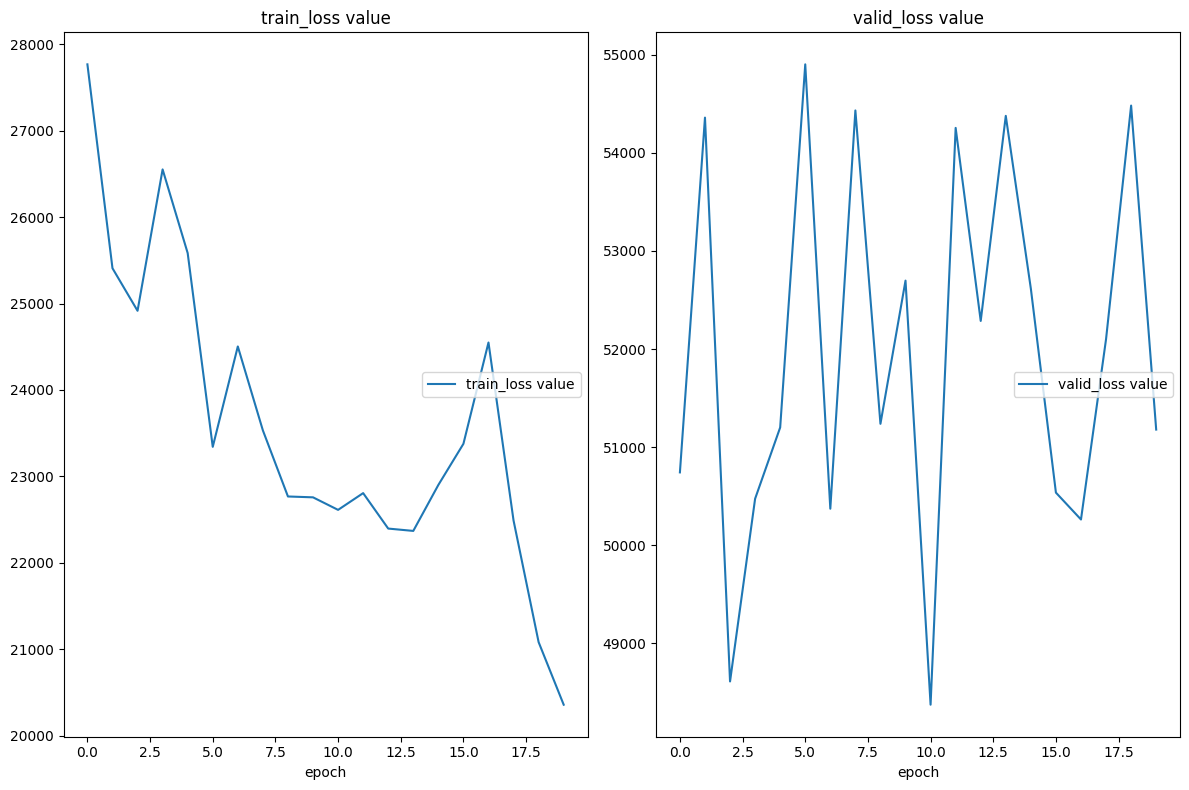

train_loss value
	train_loss value 	 (min: 20356.844, max: 27768.907, cur: 20356.844)
valid_loss value
	valid_loss value 	 (min: 48373.358, max: 54902.789, cur: 51178.698)
rmse: 261.7090064697703
mae: 204.00467426932636


In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
for i in range(10):

  optimizer = Adam(model.parameters())
  loss_fn = NextEventLoss()
  num_epochs = 20
  start_time = time.time()
  train_next(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs)
  t = time.time() - start_time
  t = round(t)
  joblib.dump(model, "Trained_models/lstmsnext_model_finalbusiness_{0}_{1}.pkl".format(i, t))
  next_event_old, labels_old = predict(model, valid_loader)
  labels_old = labels_old.reset_index()
  labels_old = labels_old.drop(["index"], axis = 1)
  df_old = pd.concat([labels_old, next_event_old], axis = 1)
  df_old.columns = ["labels", "next_event"]
  df_sorted = df_old.copy()
  rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
  mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
  print(f"rmse: {rmse}")
  print(f"mae: {mae}")
  df_sorted["labels_label"] = 0
  df_sorted["next_event_label"] = 0
  for i in range(len(df_sorted)):
    if df_sorted["labels"][i] < 117:
      df_sorted["labels_label"][i] = 1
    elif 117 < df_sorted["labels"][i] < 295:
      df_sorted["labels_label"][i] = 2
    elif 295 < df_sorted["labels"][i] < 411:
      df_sorted["labels_label"][i] = 3
    else:
      df_sorted["labels_label"][i] = 4
    if df_sorted["next_event"][i] < 117:
      df_sorted["next_event_label"][i] = 1
    elif 117 < df_sorted["next_event"][i] < 295:
      df_sorted["next_event_label"][i] = 2
    elif 295 < df_sorted["next_event"][i] < 411:
      df_sorted["next_event_label"][i] = 3
    else:
      df_sorted["next_event_label"][i] = 4
  precision_score = sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  recall_score = sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  f1_score = sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  rmse_list.append(rmse)
  mae_list.append(mae)
  precision_list.append(precision_score)
  recall_list.append(recall_score)
  f1_list.append(f1_score)
  time_list.append(t)

In [ ]:
print(np.mean(rmse_list))
print(np.mean(mae_list))
print(np.mean(precision_list))
print(np.mean(recall_list))
print(np.mean(f1_list))

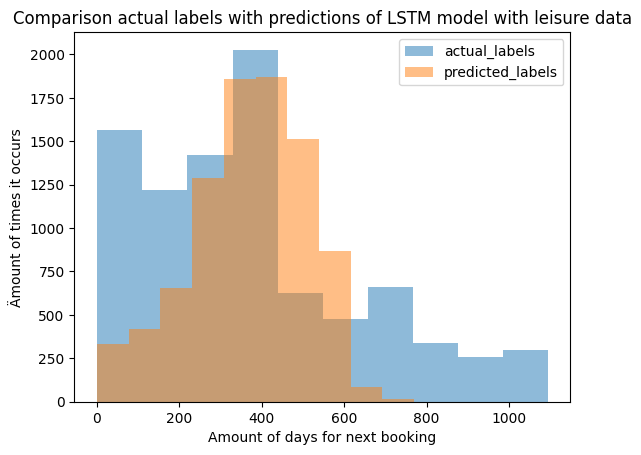

In [ ]:
plt.hist(df_sorted["labels"], alpha = 0.5, label ="actual_labels")
plt.hist(df_sorted["next_event"], alpha = 0.5, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of LSTM model with leisure data")
plt.xlabel("Amount of days for next booking")
plt.ylabel("Ämount of times it occurs")
plt.legend(prop ={'size': 10})

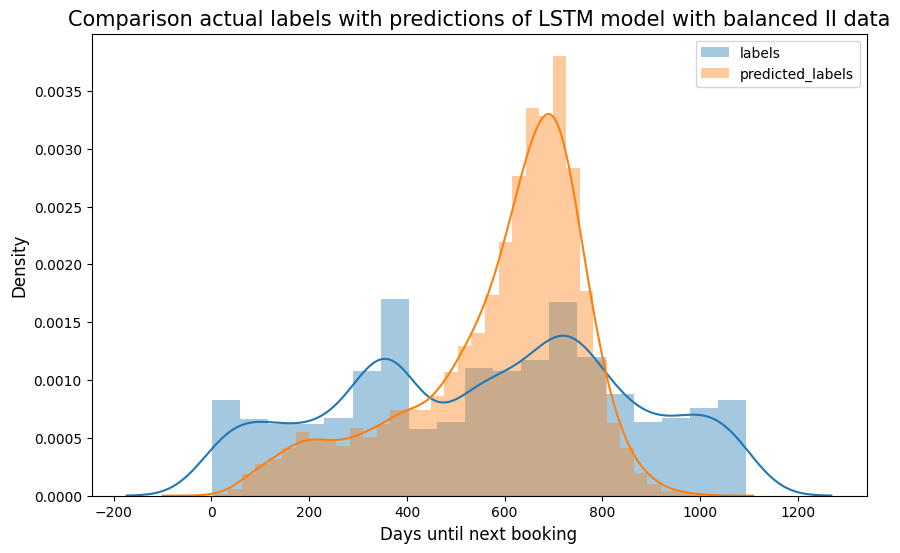

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"],hist = True, label ="labels")
sns.distplot(df_sorted["next_event"],hist = True, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of LSTM model with balanced II data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)
plt.legend()

Text(0, 0.5, 'Density')

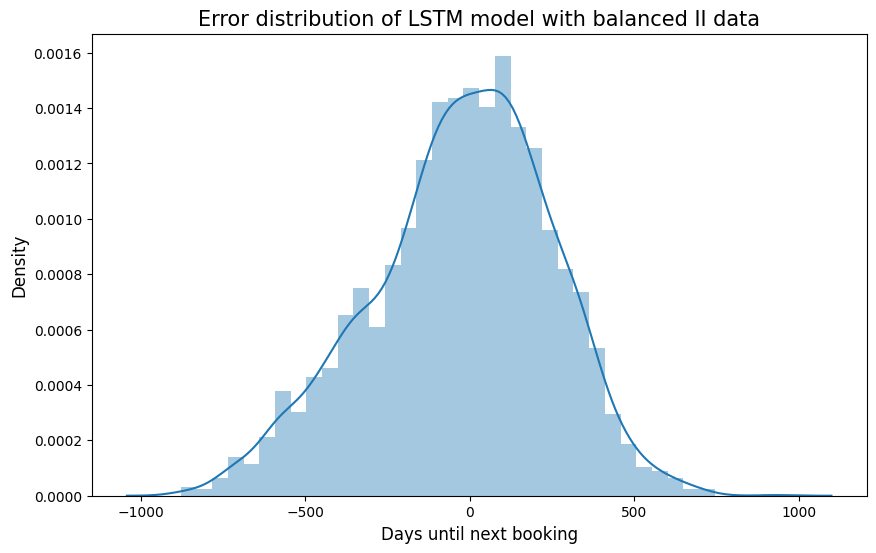

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"] - df_sorted['next_event'],hist = True)
plt.title("Error distribution of LSTM model with balanced II data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)

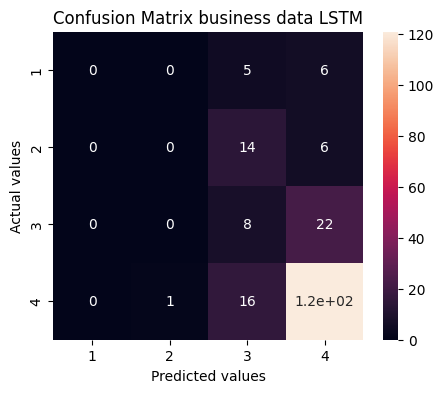

In [ ]:
cm = confusion_matrix(df_sorted["labels_label"], df_sorted["next_event_label"])
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4], columns = [1,2,3,4])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix business data LSTM")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

**SHAP**

In [ ]:
class ShapData(Dataset):
  def __init__(self, X):
    self.X = X

  def __len__(self):
    # return len(self.guests)
    return len(self.X)

  def __getitem__(self, idx):
    return torch.Tensor(self.X[idx]).reshape(1, -1)

In [ ]:
def pad_batch_shap(batch):
  # print(batch[0].shape)
  booking_seqs = batch
  seq_length = [len(booking) for booking in booking_seqs]
  padded_booking_seqs = pad_sequence(booking_seqs, batch_first=True, padding_value=-10)
  return padded_booking_seqs, seq_length

In [ ]:
guest_idx_val = data_validate.guest_idx
scaled_df_val = data_validate.scaled_df
val_guest_idx = [data_validate.guest_idx[i] for i in data_validate.split_indexes]

Index(['00006feb-5f2f-49dc-9a85-318f60e795a4',
       '00006feb-5f2f-49dc-9a85-318f60e795a4',
       '00006feb-5f2f-49dc-9a85-318f60e795a4',
       '0003bc13-8117-4e98-af2e-9d84e3721588',
       '0003bc13-8117-4e98-af2e-9d84e3721588',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '00064786-87ad-4904-830e-1f2bc29e4e6a',
       '00064786-87ad-4904-830e-1f2bc29e4e6a',
       ...
       'ffd398bb-5c7c-472e-a00a-b67ec091adfb',
       'ffd398bb-5c7c-472e-a00a-b67ec091adfb',
       'ffdbf658-f653-4411-ba02-51da0b4fd661',
       'ffdbf658-f653-4411-ba02-51da0b4fd661',
       'ffe153bd-1823-4361-8cd9-fd0a7eb5da7e',
       'ffe153bd-1823-4361-8cd9-fd0a7eb5da7e',
       'ffea76ba-71d6-47f7-82e5-74504fce130f',
       'ffea76ba-71d6-47f7-82e5-74504fce130f',
       'ffef83d5-c06c-4d49-b99b-9f717d47380f',
       'ffef83d5-c06c-4d49-b99b-9f717d47380f'],
      dtype='object', length=145530)

In [ ]:
def predict_shap(X):
  shap_data = ShapData(X)
  shap_loader = DataLoader(shap_data, batch_size=512, collate_fn=pad_batch_shap, shuffle=True)
  predictions_list = []
  for i, batch in enumerate(shap_loader):
    data, seq_length = batch
    data = data.to("cuda")
    predictions = model(data)
    predictions_list.extend(predictions.cpu().tolist()[0])
  return np.array(predictions_list)#predictions

In [ ]:
explainer = shap.KernelExplainer(predict_shap, shap.sample(scaled_df_val, 200), feature_names = scaled_df_val.columns)

  0%|          | 0/400 [00:00<?, ?it/s]

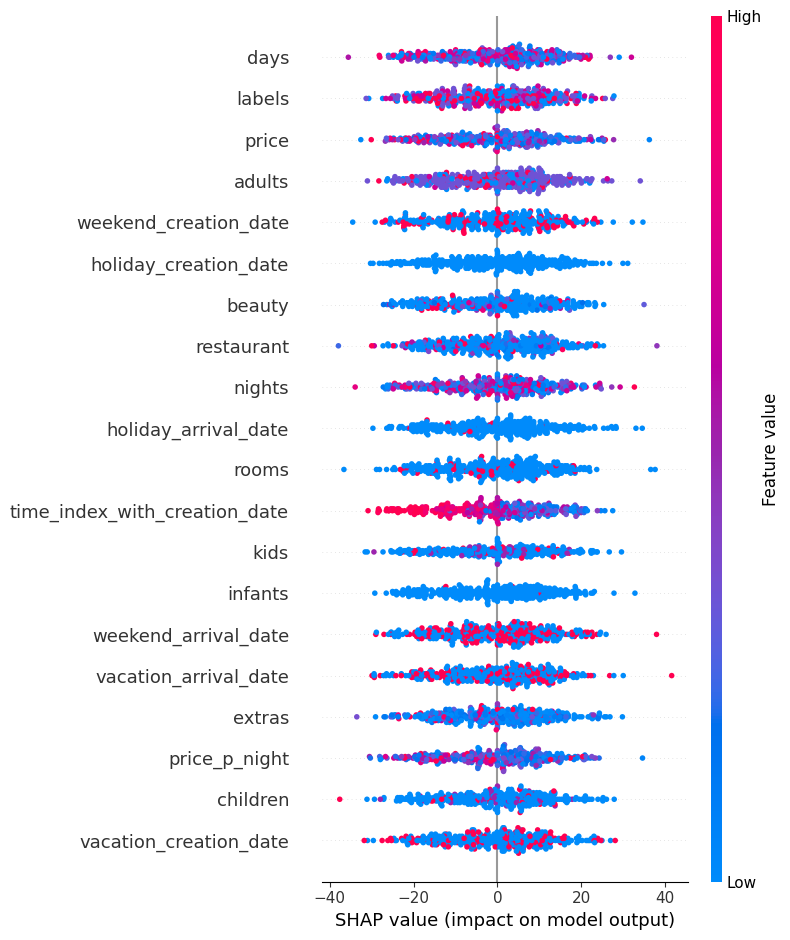

In [ ]:
shap_values = explainer.shap_values(shap.sample(scaled_df_val, 400))
shap.summary_plot(shap_values, shap.sample(scaled_df_val, 400))